# Solving the $\omega$ equation by [Green's function](https://en.wikipedia.org/wiki/Green's_function) methods
### in a small patch of atmosphere, treated as a Cartesian xyz block. The inverse Laplacian for each gridpoint of forcing decays as 1/distance (D. Nolan 2023, *pers. comm.*); how do the units and thus absolute values work? Need to follow up. 

<a id="top"></a>

### Wikipedia's version of the omega equation
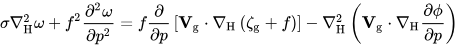 
with $\sigma$ = static stability parameter from dT/dt term  ω$\sigma$

## The Idea: 

Invert the operator on the LHS to obtain $\omega$, treating the RHS terms as a 3D array of "forcing" in some finite patch of the atmosphere. For simplicity we will treat f and $\sigma$ as constants, with a little nod of appreciation of how the stability factor $\sigma$ rescales vertical relative to horizontal components of 3D distance. 

Those forcing terms are easily computed ([bottom of notebook](#forcing_calc)), they just involve differentiation and multiplication of data arrays.  

### To do the inversion of the 3D array of forcing, there are 5 steps: 

1. Enforce $\omega$ = 0 at the surface using an ["image" or mirrored copy](https://en.wikipedia.org/wiki/Method_of_images) of the forcing, in a fictitious flipped copy of the atmosphere below the surface. This doubles the forcing array size in the vertical. Periodic rolling of the array is tantamount to another 0 boundary condition at the top of the atmospheric data block (tropopause or perhaps far above although constant static stability becomes a poor approximation in the upper atmosphere). 
2. Pad the mirrored forcing data array with zeros horizontally. This increases the now-doubled initial array size by (3x3) = 9 times. So it's a 9x bigger array than the original forcing.
3. For each gridpoint in the forcing, the induced $\omega$ is proportional to 1/distance (1/r), rescaling distance in pressure coordinates according to $r = [\Delta x^2 + \Delta y^2 + \Delta z*^2]^{1/2} = [\Delta x^2 + \Delta y^2 + (\sigma/f_o^2)\Delta p^2]^{1/2}$. If the data are interpolated onto a uniform z* vertical coordinate, we loop over all the forcing points by rolling the array systematically, and sum up all these induced contributions dividing by an also-rolled array of r we only have to calculate once.
4. In the results array, shave off all the padded and mirrored regions to recover the result.
5. Interpolate the result's vertical coordinate back to the original pressure levels, to regain the array size and shape of the forcing. 

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt

# Interpolate forcing onto a rescaled pseudo-vertical coordinate z*
### for purposes of 1/distance weighting in the Greens function sum
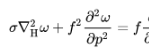
### dz* = $(\sigma / f^2)^{1/2} dp$ 
#### Let's take sigma as a constant for now, $\sigma = (T/\theta) d\theta/dp \simeq \Delta \theta / \Delta p$, so a uniform-z grid is just a uniform pressure grid. 

$\sigma = (T/\theta) d \theta / dp$ so we can understand that $\sigma dp^2 = (T/\theta) d \theta / dp (dp dp) = (T/\theta) d \theta dp$, or in words the vertical distance coordinate over which the signal decays as 1/distance is partly a "theta distance" and partly a p distance, but weighted by the p-dependent factor $T/\theta$.  In other words, more-stable layers attenuate the vertical influence of the forcing terms somewhat, and perhaps an instratified layer shields the effects entirely, but that case probably violates assumptions of the whole derivation so don't take it too literally. 

In [2]:
FDS = xr.open_dataset('./QGOE_forcing.nc') # calculated at bottom of notebook, saved in local file

In [3]:
Theta_thickness = 30 # Kelvin, tropopause depth, down-weighted for the T/theta term
sigma = Theta_thickness / (900.) # K/hPa
f0 = 1e-4 # inverse seconds
dp = FDS.level.diff('level') # hPa
dzstar = dp* np.sqrt(sigma)/f0

zstar = np.flip(dzstar).cumsum().rename('zstar') # result is on 'level' coordinate 
FDS['zstar'] = zstar
FDS = FDS.fillna( FDS.zstar[1]+dzstar[0] ) # fill the nan of zstar at 100mb 
# zstar.plot(size=2)

In [4]:
original_plevels = FDS['level'] ## for later, for interpolating back to original levels 

In [5]:
# Interpolate forcing and zstar values onto 21 uniform pressure levels... 

uniformp = np.linspace(100, 1000, 21)
FDSi = FDS.interp(level=uniformp, method='linear')
FDSi

<xarray.Dataset>
Dimensions:    (level: 21, latitude: 30, longitude: 50)
Coordinates:
  * latitude   (latitude) float32 59.62 58.62 57.62 56.62 ... 32.62 31.62 30.62
  * longitude  (longitude) float32 200.4 201.4 202.4 203.4 ... 247.4 248.4 249.4
    time       datetime64[ns] 2014-09-16T11:00:00
  * level      (level) float64 100.0 145.0 190.0 235.0 ... 910.0 955.0 1e+03
Data variables:
    TermA      (level, latitude, longitude) float64 3.794e-16 ... 1.205e-16
    TermB      (level, latitude, longitude) float64 3.498e-19 ... -1.499e-18
    Phi        (level, latitude, longitude) float64 1.587e+05 ... 1.073e+03
    Thk        (level, latitude, longitude) float64 -658.3 -658.1 ... -85.04
    zstar      (level) float64 1.689e+06 1.607e+06 ... 1.278e+05 4.564e+04

### Testing the rolling and summing algorithm visually 

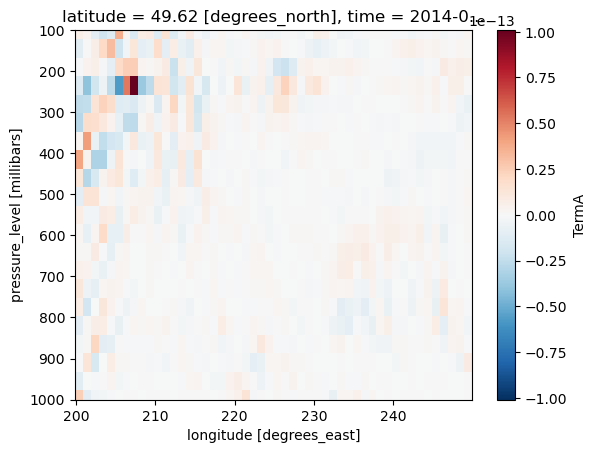

In [6]:
FDSi.TermA.isel(latitude=10).plot(ylim=[1000,100])

Text(0.5, 1.0, 'debug F shape (21, 30, 50)')

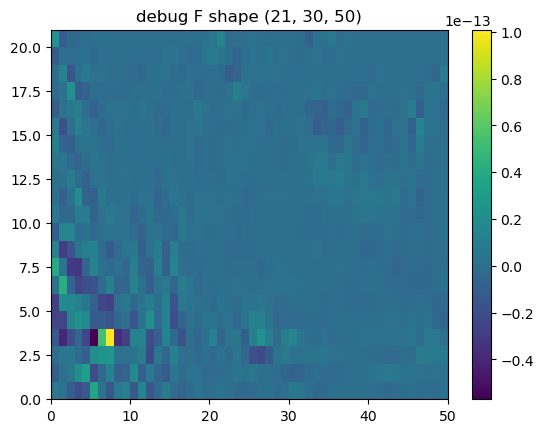

In [7]:
F = FDSi.TermA.values # + FDSi.TermB.values  # Numpy array shape (p, lat, lon)

# F = F*1e13 ## Order 1 for debugging numerical convenience 
# Keep only the upper-west forcing for debugging tests: passed! 
# F[:,:,10:] = 0 
# F[10:,:,:] = 0 

NP = F.shape[0]
NLAT = F.shape[1]
NLON = F.shape[2]

plt.pcolormesh(F[:,10,:]); plt.colorbar()
plt.title('debug F shape '+str(F.shape))

In [8]:
FDSi

<xarray.Dataset>
Dimensions:    (level: 21, latitude: 30, longitude: 50)
Coordinates:
  * latitude   (latitude) float32 59.62 58.62 57.62 56.62 ... 32.62 31.62 30.62
  * longitude  (longitude) float32 200.4 201.4 202.4 203.4 ... 247.4 248.4 249.4
    time       datetime64[ns] 2014-09-16T11:00:00
  * level      (level) float64 100.0 145.0 190.0 235.0 ... 910.0 955.0 1e+03
Data variables:
    TermA      (level, latitude, longitude) float64 3.794e-16 ... 1.205e-16
    TermB      (level, latitude, longitude) float64 3.498e-19 ... -1.499e-18
    Phi        (level, latitude, longitude) float64 1.587e+05 ... 1.073e+03
    Thk        (level, latitude, longitude) float64 -658.3 -658.1 ... -85.04
    zstar      (level) float64 1.689e+06 1.607e+06 ... 1.278e+05 4.564e+04

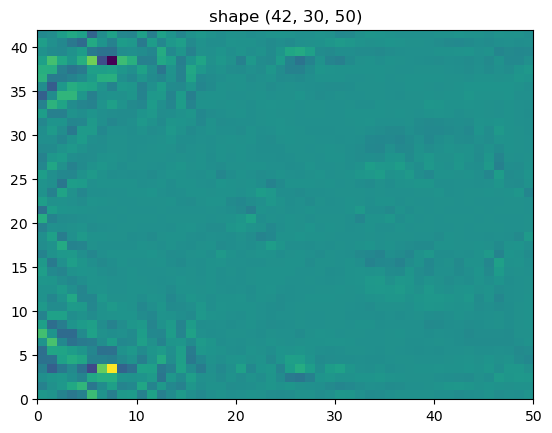

In [9]:
# Mirroring 

mirF = np.concatenate((F, -F[::-1]), axis=0) 
plt.pcolormesh(mirF[:,10,:])
plt.title('shape ' + str(np.shape(mirF))); 

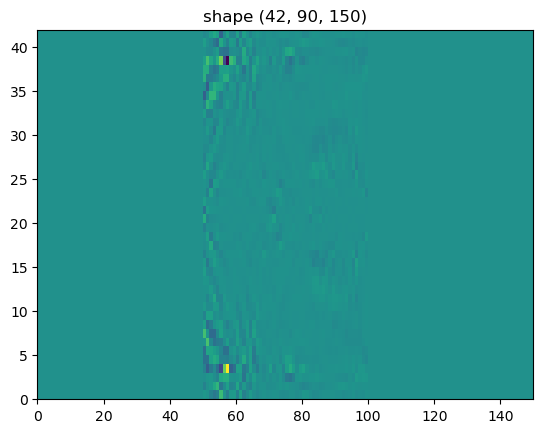

In [26]:
# Specify the padding size for each dimension
# No need for vertical padding (mirror BC across data top)

padding_size = ((0, 0), (NLAT, NLAT), (NLON, NLON))

# Pad the array with zeros
padF = np.pad(mirF, padding_size, mode='constant', constant_values=0)
plt.pcolormesh(padF[:,10+NLAT,:])
plt.title('shape '+str( padF.shape )); 

# Compute distance array to divide by
### Compute it for one point in the center

Then roll() 1/r along with the data during the big sum. 1/distance is measured with the zstar computed above. 

In [11]:
# Coordinate scalings for 1/r distance calculation, Cartesian tangent verion 
dy = float(FDS.latitude.diff('latitude').mean().values)  * 111111.1 # meters
dx = float(FDS.longitude.diff('longitude').mean().values * 111111.1 *\
            np.cos(FDS.latitude *np.pi/180.).mean() ) # meters
dzstar = float(FDSi.zstar.diff('level').mean().values) # pseudo meters? 

dx, dy, dzstar  ## Meters, and pseudo-meters in zstar

(77504.33570625783, -111111.1, -82158.3836257749)

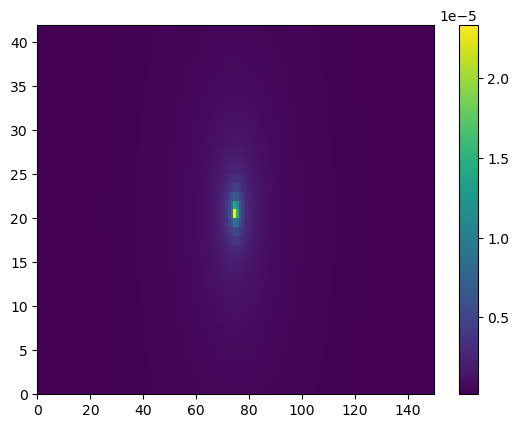

In [12]:
# Numpy array shape NP,NLAT,NLON (p, lat, lon)

# Get the center coordinates
shape = padF.shape
center = np.array([(dim - 1) / 2 for dim in shape])
# Create a grid of indices
indices = np.indices(shape)

# Calculate the 3 coordinate distances from the central point, avoiding zeros for 1/distance 
coord_distances = (indices - center[:, None, None, None] + 0.23)
coord_distances[0,:,:,:] *= dzstar
coord_distances[1,:,:,:] *= dy
coord_distances[2,:,:,:] *= dx

# sum the square over the 3 dimensions 
dist = np.sqrt(np.sum( coord_distances**2, axis=0))
invdist = 1.0/dist
plt.pcolormesh(invdist[:,14+NLAT,:]); plt.colorbar()
# plt.title('Inverse of distance in xz plane');

In [13]:
invdist.shape

(42, 90, 150)

In [27]:
%timeit 

# 3D smoothing by Laplacian inversion. Sum of rolled offsets of padF/distance.
# Both arrays are rolled, to center each point of the forcing and broadcast its influence 
# to the entire results array. 
# Rolls are negative to put the unpadded part of result into the easiest corner 

# Numpy array shape (p, lat, lon)
# Number of rolls in each direction
rolls_x, rolls_y = NLON, NLAT

result = padF*0 # correct shaped array 

# Roll the inverse distance array over the whole data-containing parf of padF. 
# scale that array by the forcing at its zero point, and accumulate a sum . 
# First loop accesses the original data, then other rolls work on the rolled array

for i in range(-NLON//2, NLON//2):
    print('longitude ',i) 
    for j in range(-NLAT//2, NLAT//2):
        for k in range(-NP, NP):
            
            # invdist spatial pattern, weighted by forcing strength
            rollinvdist = np.roll(invdist, [k,j,i], axis=(0, 1, 2))

            # Middle of the paddded array is NP, but NLAT + NLAT//2 etc. 
            Fvalue = padF[NP +k, NLAT+NLAT//2 +j, NLON+NLON//2 +i] 

            result += Fvalue * rollinvdist 

longitude  -25
longitude  -24
longitude  -23
longitude  -22
longitude  -21
longitude  -20
longitude  -19
longitude  -18
longitude  -17
longitude  -16
longitude  -15
longitude  -14
longitude  -13
longitude  -12
longitude  -11
longitude  -10
longitude  -9
longitude  -8
longitude  -7
longitude  -6
longitude  -5
longitude  -4
longitude  -3
longitude  -2
longitude  -1
longitude  0
longitude  1
longitude  2
longitude  3
longitude  4
longitude  5
longitude  6
longitude  7
longitude  8
longitude  9
longitude  10
longitude  11
longitude  12
longitude  13
longitude  14
longitude  15
longitude  16
longitude  17
longitude  18
longitude  19
longitude  20
longitude  21
longitude  22
longitude  23
longitude  24


(0, 0, 0)

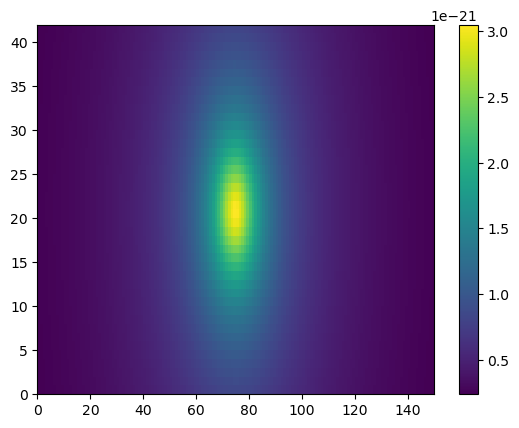

In [33]:
i,j,k = 0,0,0

#i,j,k = -NLON//2,0,-NP//2

rollinvdist = np.roll(invdist, [k,j,i], axis=(0, 1, 2))

Fvalue = padF[NP//2+k, NLAT+NLAT//2+j, NLON+NLON//2+i] 

test = Fvalue * rollinvdist 

plt.pcolormesh(test[:,40,:]); plt.colorbar()
i,j,k

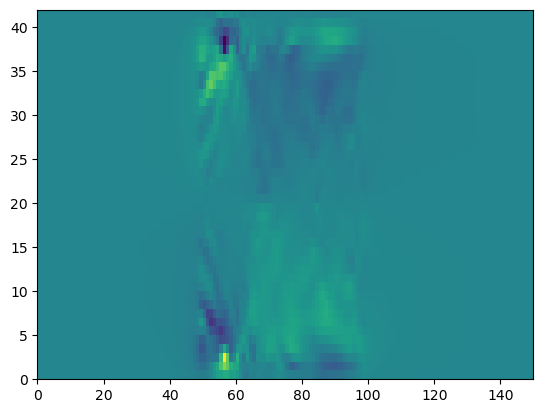

In [30]:
plt.pcolormesh(result[:,40,:])

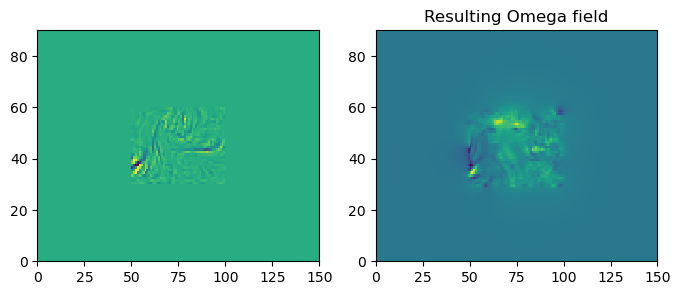

In [35]:
# Plot Result in middle troposphere: horizontal structure looks right 
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].pcolormesh(padF[5,:,:])
axs[1].pcolormesh(result[15,:,:])
plt.title('Resulting Omega field');

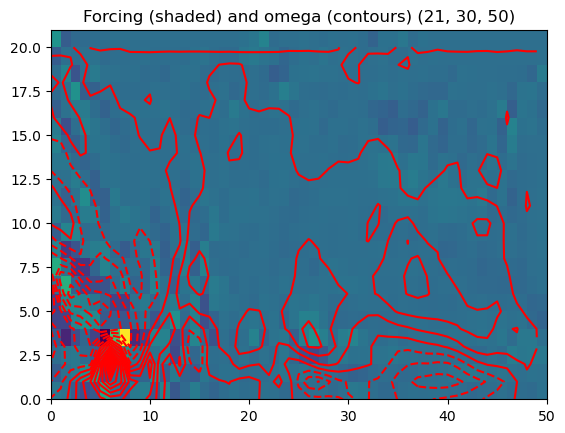

In [36]:
# Extract the middle 1/3 along each dimension, and troposphere array in right order

for_core = padF  [:NP, NLAT:2*NLAT, NLON:2*NLON]
res_core = result[:NP, NLAT:2*NLAT, NLON:2*NLON]

plt.pcolormesh(for_core[:,10,:])
plt.contour   (res_core[:,10,:], colors='red', levels=20)

plt.title('Forcing (shaded) and omega (contours) '+str( res_core.shape )); 

In [37]:
# Create a new DataArray with the same coordinates as the existing DataArrays
res_da = xr.DataArray(-res_core,
                    dims=['level','latitude', 'longitude'],
                    coords={'level':FDSi.level, 'latitude': FDSi.latitude, 'longitude': FDSi.longitude})
res_da
# Update the Dataset with the new DataArray
FDSi.update({'QGomega': res_da})

<xarray.Dataset>
Dimensions:    (level: 21, latitude: 30, longitude: 50)
Coordinates:
  * latitude   (latitude) float32 59.62 58.62 57.62 56.62 ... 32.62 31.62 30.62
  * longitude  (longitude) float32 200.4 201.4 202.4 203.4 ... 247.4 248.4 249.4
    time       datetime64[ns] 2014-09-16T11:00:00
  * level      (level) float64 100.0 145.0 190.0 235.0 ... 910.0 955.0 1e+03
Data variables:
    TermA      (level, latitude, longitude) float64 3.794e-16 ... 1.205e-16
    TermB      (level, latitude, longitude) float64 3.498e-19 ... -1.499e-18
    Phi        (level, latitude, longitude) float64 1.587e+05 ... 1.073e+03
    Thk        (level, latitude, longitude) float64 -658.3 -658.1 ... -85.04
    zstar      (level) float64 1.689e+06 1.607e+06 ... 1.278e+05 4.564e+04
    QGomega    (level, latitude, longitude) float64 2.691e-20 ... -2.861e-21

In [38]:
# Interpolate back onto original pressure levels... 
FDSi = FDSi.interp(level=original_plevels, method='linear')
FDSi

<xarray.Dataset>
Dimensions:    (level: 27, latitude: 30, longitude: 50)
Coordinates:
  * latitude   (latitude) float32 59.62 58.62 57.62 56.62 ... 32.62 31.62 30.62
  * longitude  (longitude) float32 200.4 201.4 202.4 203.4 ... 247.4 248.4 249.4
    time       datetime64[ns] 2014-09-16T11:00:00
  * level      (level) int32 100 125 150 175 200 225 ... 900 925 950 975 1000
Data variables:
    TermA      (level, latitude, longitude) float64 3.794e-16 ... 1.205e-16
    TermB      (level, latitude, longitude) float64 3.498e-19 ... -1.499e-18
    Phi        (level, latitude, longitude) float64 1.587e+05 ... 1.073e+03
    Thk        (level, latitude, longitude) float64 -658.3 -658.1 ... -85.04
    zstar      (level) float64 1.689e+06 1.643e+06 ... 9.129e+04 4.564e+04
    QGomega    (level, latitude, longitude) float64 2.691e-20 ... -2.861e-21

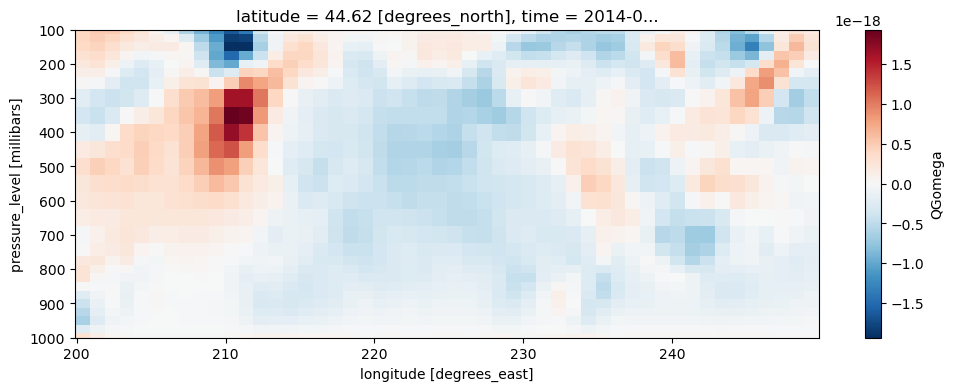

In [39]:
FDSi.QGomega.sel(latitude=45, method='nearest').plot( ylim=[1000,100], size=4, aspect=3)

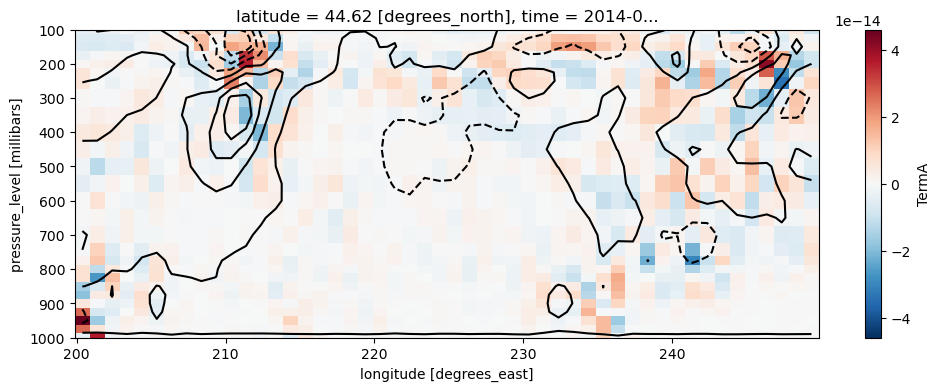

In [45]:
FDSi.TermA.sel(latitude=45, method='nearest').plot(size=4, aspect=3)
FDSi.QGomega.sel(latitude=45, method='nearest').plot.contour(ylim=[1000,100], colors='black', levels=10)

-------------------------
<a id="forcing_calc"></a>

# Calculate the forcing terms from a dataset 

[top](#top)

In [ ]:
import xarray as xr 
import windspharm
import numpy as np
import matplotlib.pyplot as plt

grav = 9.81 # m/s units 
Omega = 2*np.pi / 86164. #86400. # inverse second units, angular rotation rate of earth

In [ ]:
DEM05 = xr.open_dataset('./DEM.halfdeg.nc')
# roll to 0-360 lon form, thanks chatGPT for the quickie
DEM05 = DEM05.roll(lon=(DEM05.sizes['lon'] // 2))
DEM05['lon'] = (DEM05['lon'] + 180) % 360

def coastline(**kwargs): 
    DEM05.z.plot.contour(vmin=0, vmax=0.01, **kwargs)
    
# DEM05.z.plot(size=2,aspect=2.5);

In [ ]:
e54d = xr.open_dataset('/Users/bmapes/Box/era5_3D_3hours_20140916.nc')

# Select central time (index 1) as the 3D fields for spherical analysis 
e53d = e54d.isel({'time':1})
e53d

In [ ]:
u = e53d['u']
v = e53d['v']
V = windspharm.xarray.VectorWind(u, v)   

avor = V.absolutevorticity()
f = V.planetaryvorticity()
davordx, davordy = V.gradient(avor)
avoradv = -u*davordx - v*davordy

In [ ]:
# Glance at 200mb vorticity advection field as a check, smoothed

V.truncate(avoradv, truncation=42).sel(level=200).plot(size=4, aspect=2.5)
e53d.z.sel(level=200).plot.contour(levels=20)
coastline(colors='k');

In [ ]:
# Construct thickness dPhi/dp and its horizontal advection at say 850

Phi = e53d.z
dphidp = Phi.differentiate('level')

# dphidp.mean(['latitude','longitude']).plot()  
# negative, about -100 in troposphere

thk = dphidp
dthkdx,dthkdy = V.gradient(dphidp)
thk_adv = -u*dthkdx - v*dthkdy

In [ ]:
# Notice that thk is NEGATIVE, so its advection rate is negative for WAA

V.truncate(thk_adv, truncation=42).sel(level=850).plot(size=4, aspect=2.5)
Phi.sel(level=850).plot.contour(levels=20)
coastline(colors='k');

-------------------
## At last, the terms we want. 
#### Double check their sign and size and stuff... for now, just need right shape for top job 
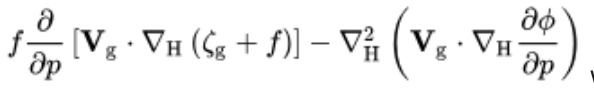

In [ ]:
# Use total winds and total vorticity; notice advection is MINUS V.del
TERMA = -f * avoradv.differentiate('level')  # units of inverse seconds per MILLIBAR ### 10-13 values

In [ ]:
# Laplacian of thickness advection: 
gradx, grady = V.gradient(thk_adv)
gradTA = windspharm.xarray.VectorWind(gradx, grady)
LapTA = gradTA.divergence()

In [ ]:
TERMB = f * LapTA  ### 10-16 values, 1000x smaller than TERMA, something needs revisiting... 

## Grab a box in the NEpac for testing, and coarsen to 1 degree 

In [ ]:
FA = TERMA.sel(latitude=slice(60,30.01), longitude=slice(200,250-0.01), level=slice(100,1000))
FB = TERMB.sel(latitude=slice(60,30.01), longitude=slice(200,250-0.01), level=slice(100,1000))

In [ ]:
FDS = FA.to_dataset(name='TermA')

In [ ]:
FDS = FA.to_dataset(name='TermA')
FDS['TermB'] = TERMB
FDS['Phi'] = Phi.sel(latitude=slice(60,30), longitude=slice(200,250), level=slice(100,1000))
FDS['Thk'] = thk.sel(latitude=slice(60,30), longitude=slice(200,250), level=slice(100,1000))

FDS = FDS.coarsen(latitude=4, longitude=4).mean()
FDS.to_netcdf('./QGOE_forcing.nc')
FDS

In [ ]:
FA.max() # size of the numbers quicklook

In [ ]:
FB.max()